# Import and loading

In [13]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
from utils.data_processor import Data_processor
from utils.evaluator import Evaluator

import pandas as pd
from sklearn import tree
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import prince
import numpy as np

In [14]:
data = Loader.load_by_fueltype("Combustion")
label_encoder = LabelEncoder()

/home/nitram/asignaturas/machine learning/Cars_Price_Prediction/Trees/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/nitram/asignaturas/machine learning/Cars_Price_Prediction/Trees/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/nitram/asignaturas/machine learning/Cars_Price_Prediction/Trees/../utils/loader.py:165: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, t

# Functions

In [15]:
def drop_columns_full_nan(data: pd.DataFrame) -> pd.DataFrame:
    #Remove the column that only contain NAs
    cols_to_drop = data.columns[data.isna().all()]
    data = data.drop(cols_to_drop, axis=1)
    return data

def get_combustion_numerical_columns (data: pd.DataFrame) -> pd.DataFrame:
    numerical_columns = data.select_dtypes(include=['number'])

    #if all the values of the numerical columns is 0, we rem['Combustion']ove the column
    cols_to_drop = numerical_columns.columns[(numerical_columns == 0).all()]
    numerical_columns = numerical_columns.drop(cols_to_drop, axis=1)
    return numerical_columns

def fill_combustion_numerical_columns(numerical_columns: pd.DataFrame) -> pd.DataFrame:
    cols_mode = ['displacement_liters','doors','seatingCapacity','number_of_cylinders','cubicCapacity',"dimensions.length","dimensions.height","Llantas_Diametro_cm","number_of_cylinders","bore_diameter","stroke_length"]
    #fill the elemental columns that has a minor amount of missing data with the mode
    for col in cols_mode:
        numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, col)

    #fill the missing data witch regression, the parameters were based on the relation matrix 
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height"], y_column="dimensions.width")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height", "dimensions.width"], y_column="trunkCapacityInLiters")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw"], y_column="maxSpeed")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="max_torque_nm")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="rpm_max_torque")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="rpm_max_power")
    numerical_columns.dropna(axis=1, inplace=True)
    return numerical_columns

def get_combustion_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    # Select and print only the categorical columns
    ret = df.select_dtypes(include=['category'])
    
    # Temporarily convert the column to strings to perform the replacement
    ret['traction'] = ret['traction'].astype(str).replace({"trasera": "trasero", "delantera": "delantero"})
    # Convert back to a categorical type
    ret['traction'] = ret['traction'].astype('category')

    
    # Remove redundant columns if this function is defined
    ret = Data_processor.remove_redundand_columns(ret)
    return ret


def fill_combustion_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    mode_cols = ['brakes','version','jato_classification']
    for col in mode_cols:
        df = Data_processor.fill_na_with_mode(df, col)
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model", "traction","brakes"], Y="front_suspension")
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model", "traction","brakes"], Y="rear_suspension")
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model"] , Y="environmentalLabel")
    return df

def category_convert(df: pd.DataFrame) -> pd.DataFrame:
    cols_to_convert = df.select_dtypes(include=['object']).columns
    for col in cols_to_convert:
        df[col] = df[col].astype('category')
    return df


# Column filters

In [16]:
# Quit all electric columns from data['Combustion']
for column in data.columns:
    if column.startswith('electric'):
        data = data.drop(columns=column)
pd.set_option('display.max_rows', None)

In [17]:
# convert object columns to category
data = category_convert(data)

categorical_columns = get_combustion_categorical_columns(data)

categorical_columns = fill_combustion_categorical_columns(categorical_columns)

# Check amount of missing values
missing_values = categorical_columns.isnull().sum()
missing_values = missing_values[missing_values > 0]

print(missing_values)
categorical_columns.head()
categorical_columns.columns
#categorical_columns['traction']

Series([], dtype: int64)


Index(['color', 'brand', 'model', 'version', 'fuelType', 'bodyTypeId',
       'transmissionTypeId', 'province', 'environmentalLabel',
       'jato_classification', 'traction', 'brakes', 'front_suspension',
       'rear_suspension', 'Acabado Exterior_Alerón',
       'Acabado Exterior_Cristales', 'Acabado Exterior_Faldones',
       'Acabado Exterior_Pintura', 'Acabado Exterior_Rueda', 'AC_Zones',
       'AC_Type', 'Metodo_Apertura', 'Tipo_Faro', 'interior_clock',
       'arm_suppport_front', 'arm_suppport_back', 'price_categ'],
      dtype='object')

In [18]:
# Drop all na columns 
data = drop_columns_full_nan(data)

numerical_columns = get_combustion_numerical_columns(data)


# fill the missing data in numerical columns
numerical_columns = fill_combustion_numerical_columns(numerical_columns)

# Check amount of missing values
missing_values_num = numerical_columns.isnull().sum()
missing_values_num = missing_values_num[missing_values_num > 0]

data[numerical_columns.columns] = numerical_columns

#correlation_matrix = numerical_columns.corr()
#correlation_matrix = correlation_matrix.sort_values(by='price', ascending=False)
print(missing_values_num)

Regression mape ['dimensions.length', 'dimensions.height'] -> dimensions.width: 1.6154091221985638%
Regression mape ['dimensions.length', 'dimensions.height', 'dimensions.width'] -> trunkCapacityInLiters: 17.70914536272188%
Regression mape ['power_cv', 'power_kw'] -> maxSpeed: 6.410215656255149%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 7.903819131160306%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 6.82454077343871%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> max_torque_nm: 2.5518090259601084e+16%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> rpm_max_torque: 67.97560330483189%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> rpm_max_power: 20.028480167086318%
Series([], dtype: int64)


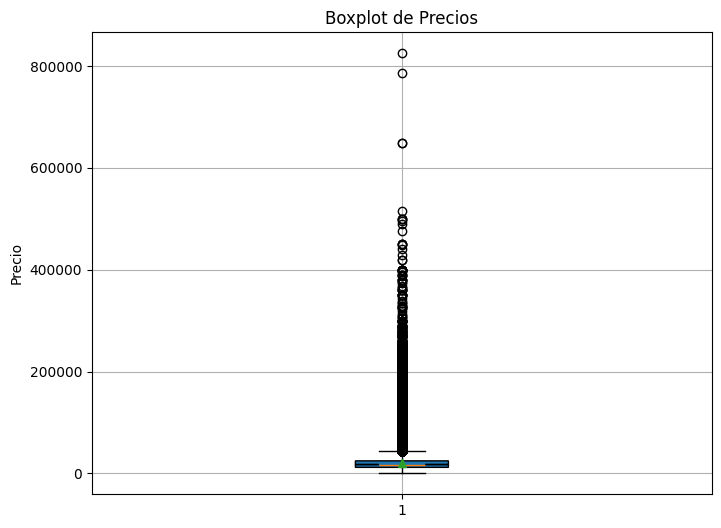

In [19]:
precios_combustion = data["price"]
plt.figure(figsize=(8, 6))
plt.boxplot(precios_combustion, notch=True, vert=True, patch_artist=True, showmeans=True)
plt.title('Boxplot de Precios')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

Even though there seems to be many outliers in the data, after a manual inspection, it was found that the data is correct and the outliers are valid data points. (Most of them are from luxury brands such as Lamborghini, Ferrari, etc.)

In [20]:
Q1 = data['price'].quantile(0.25)
Q2 = data['price'].quantile(0.5)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

upper_whisker = (Q3 + 1.5 * IQR)
print(upper_whisker)

data[data["price"]>upper_whisker][["price", "brand"]].sort_values(by='price', ascending=False)[:10]

43901.5


,price,brand
idx,,
48458,825000,MERCEDES-BENZ
38166,786500,FERRARI
18873,648500,FERRARI
16685,648500,FERRARI
119510,515000,PORSCHE
16086,499900,FERRARI
78396,499900,LAMBORGHINI
76218,499900,LAMBORGHINI
19151,495000,LAMBORGHINI


# PCA

In [21]:
scaler = StandardScaler()
df_scaled  = scaler.fit_transform(numerical_columns)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

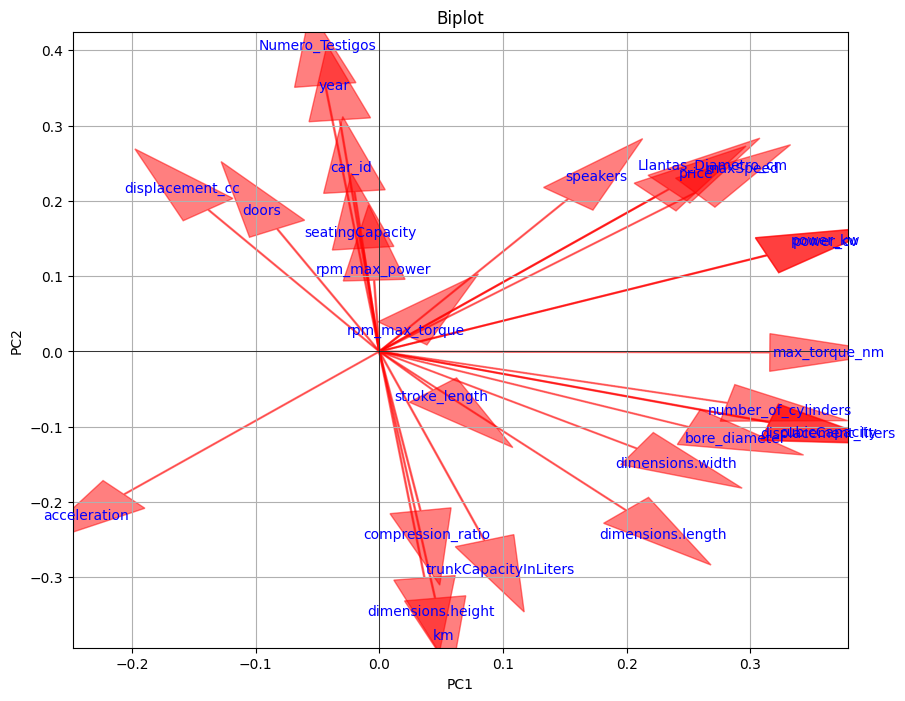

In [22]:
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(10, 8))
    origin = [0, 0]  # Origen de las flechas

    # Dibujar las flechas
    for i in range(len(coeff)):
        plt.arrow(origin[0], origin[1], coeff[i,0], coeff[i,1], color='r', alpha=0.5, head_width=0.05, head_length=0.1)
        if labels is not None:
            plt.text(coeff[i,0]*1.15, coeff[i,1]*1.15, labels[i], color='blue', ha='center', va='center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot")
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.xlim(min(coeff[:,0])*1.2, max(coeff[:,0])*1.2)
    plt.ylim(min(coeff[:,1])*1.2, max(coeff[:,1])*1.2)
    plt.show()

# Llamada a la función biplot
biplot(principal_components, np.transpose(pca.components_[0:2, :]), labels=numerical_columns.columns)

# Test CART regression trees with only numerical variables

In [23]:
X = numerical_columns.drop(columns="price")
y = numerical_columns["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

MAE: 2259.4433620827435 
 MSE: 54951566.10737143 
 RMSE: 7412.9323555102965 
 R2: 0.8741384310614646 
 MAPE: 12.04420451573805
Mean: 2259.4433620827435
Variance: 49846481.80091166
Standard Deviation: 7060.204090599057


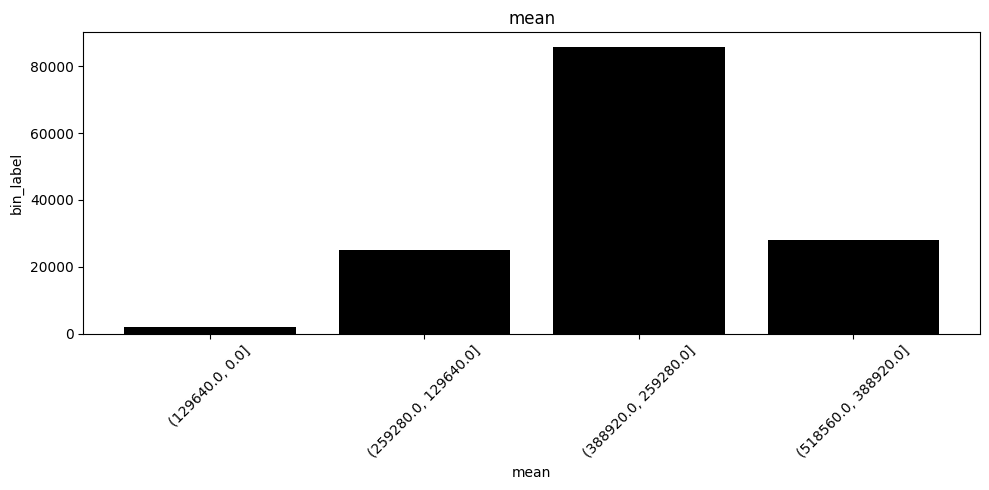

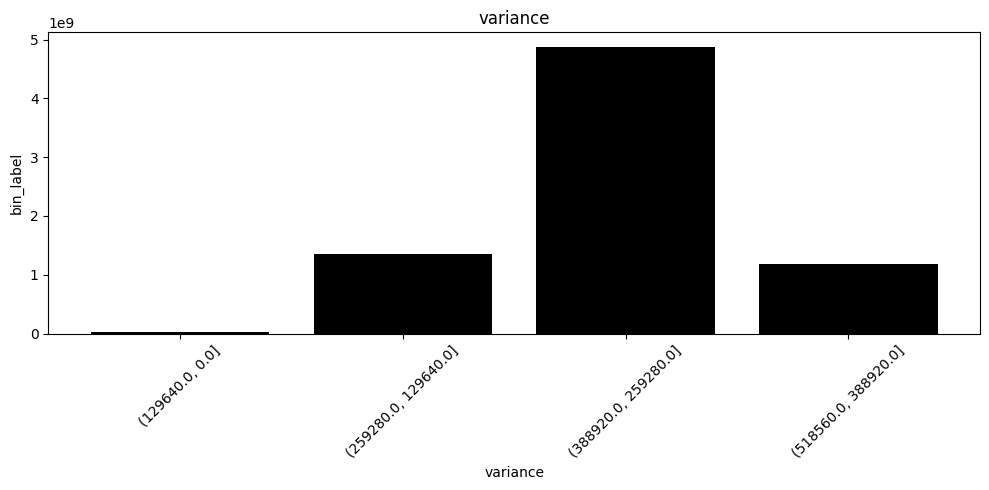

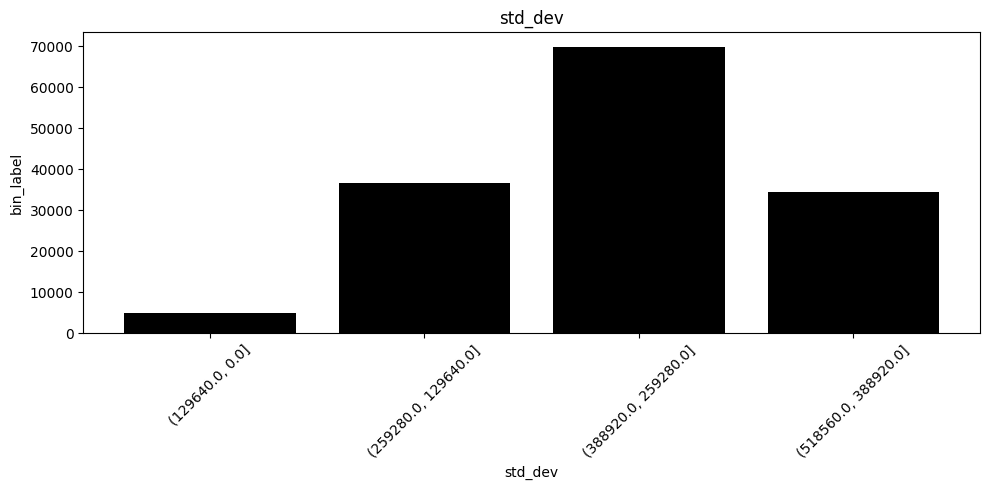

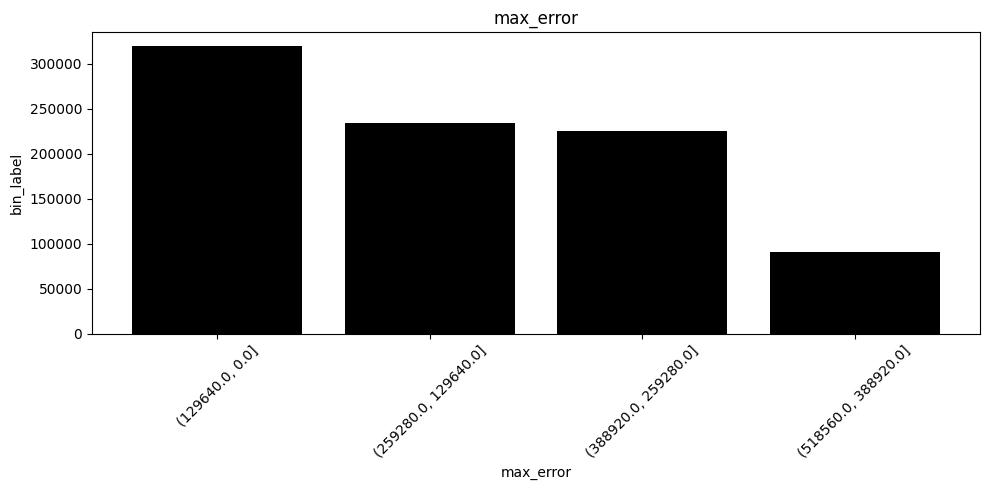

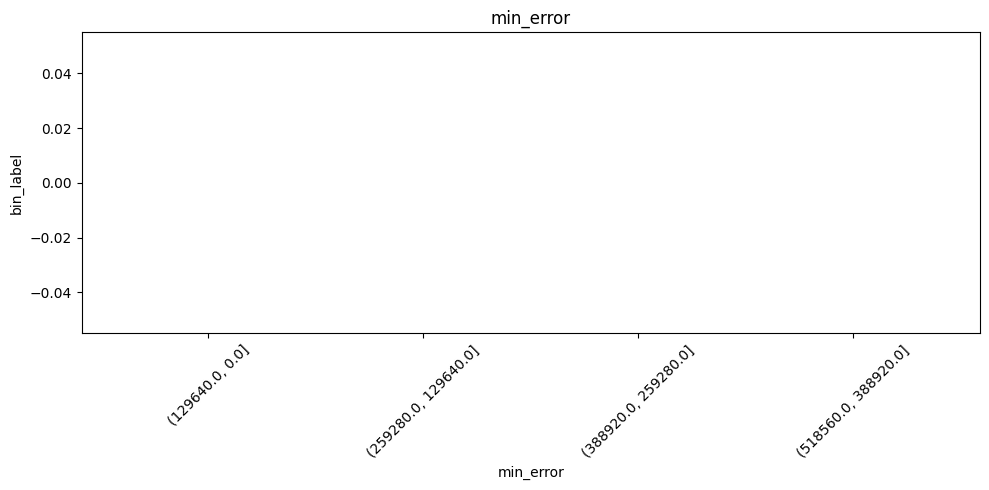

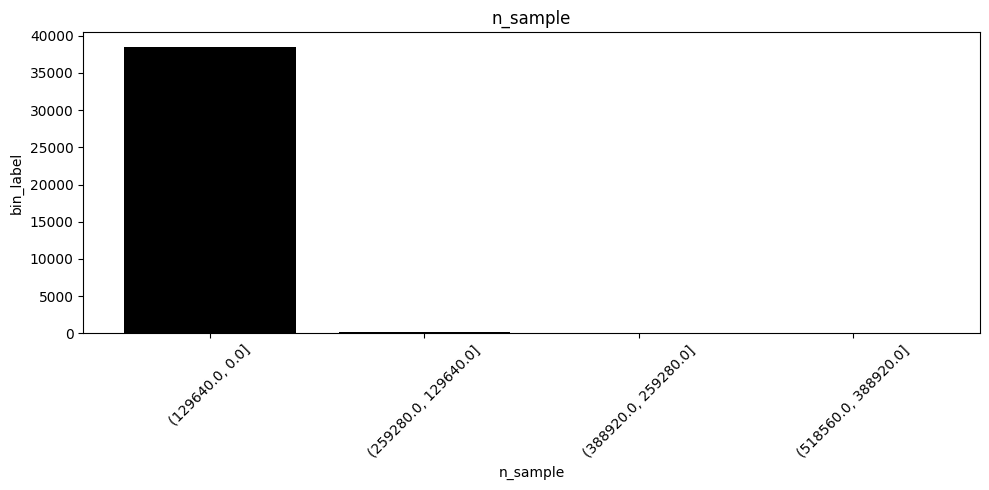

,bin_label,mean,variance,std_dev,max_error,min_error,n_sample
0,"(129640.0, 0.0]",2063.490998,2.371189e+07,4869.485919,319000.0,0.0,38536
1,"(259280.0, 129640.0]",25081.639037,1.344759e+09,36670.955145,234290.0,0.0,187
2,"(388920.0, 259280.0]",85929.290323,4.878283e+09,69844.705368,225100.0,0.0,31
3,"(518560.0, 388920.0]",28030.000000,1.177892e+09,34320.433175,90100.0,0.0,6


In [24]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Realizar predicciones sobre el conjunto de prueba
y_pred = tree_model.predict(X_test)

Evaluator.eval_regression(y_pred, y_test)

# CA

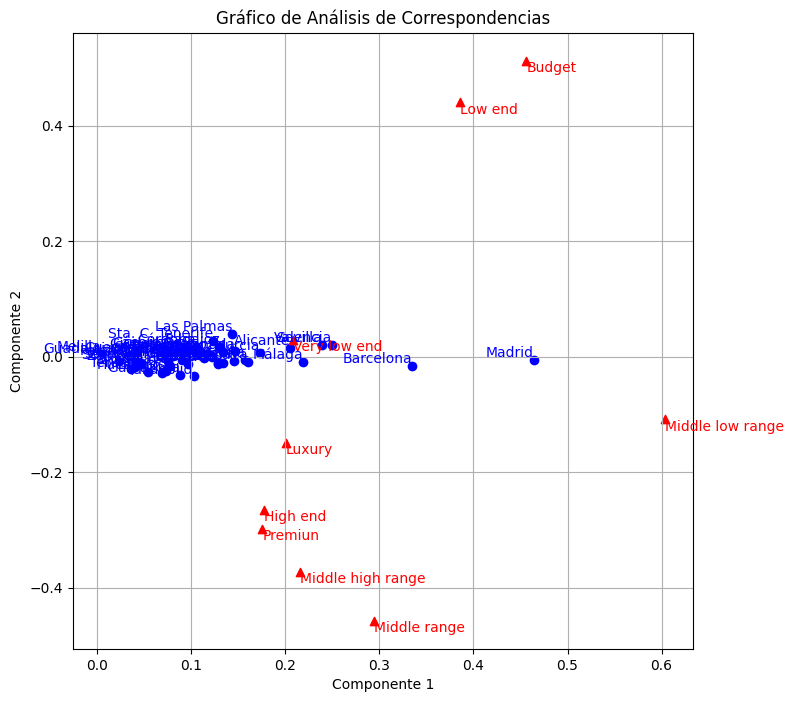

In [26]:
Data_processor.CA(categorical_columns=categorical_columns, col_x="province", col_y="price_categ")

In [27]:
categorical_columns["price_categ"].value_counts()

price_categ
Middle low range     47015
Budget               26867
Low end              19272
Middle range         11219
Middle high range     6014
Very low end          5609
Luxury                5182
High end              4049
Premiun               3977
Name: count, dtype: int64

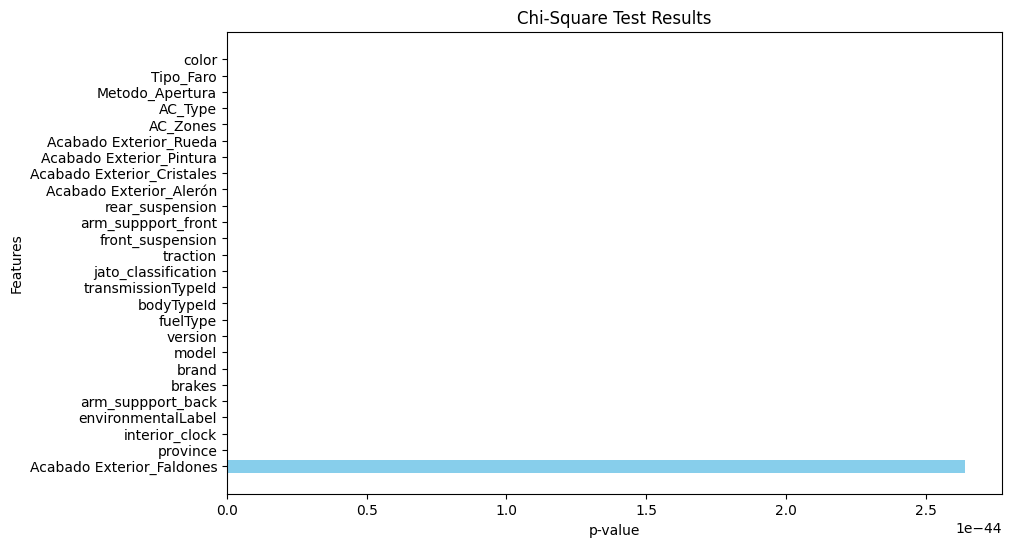

Index(['color', 'Tipo_Faro', 'Metodo_Apertura', 'AC_Type', 'AC_Zones',
       'Acabado Exterior_Rueda', 'Acabado Exterior_Pintura',
       'Acabado Exterior_Cristales', 'Acabado Exterior_Alerón',
       'rear_suspension', 'arm_suppport_front', 'front_suspension', 'traction',
       'jato_classification', 'transmissionTypeId', 'bodyTypeId', 'fuelType',
       'version', 'model', 'brand', 'brakes', 'arm_suppport_back',
       'price_categ'],
      dtype='object')

In [28]:
categorical_columns = Data_processor.chi_square_filter(categorical_columns, "price_categ", p_value_filter=0)
categorical_columns.columns

In [29]:
columns = list(categorical_columns.columns)
columns.remove("price_categ")
for col in columns:
    categorical_columns[col] = label_encoder.fit_transform(categorical_columns[col])

# Preparar los datos
X = categorical_columns.drop(columns=["price_categ"])
Y = categorical_columns["price_categ"].apply(lambda x: Loader.encode_price_categ(x))

# Dividir los datos en entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

# Crear el modelo de árbol de decisión
tree_model = DecisionTreeClassifier(random_state=42, criterion = "entropy")

# Entrenar el modelo
tree_model.fit(X_train, Y_train)

# Predecir las etiquetas del conjunto de prueba
Y_pred = tree_model.predict(X_test)

In [34]:
result = pd.DataFrame({"Real_Categorie": Y_test, "Prediction": Y_pred})
result["diff"] = np.abs(result["Real_Categorie"].astype(int) - result["Prediction"])
result["Real_Categorie"] = result["Real_Categorie"].apply(Loader.decode_price_categ)
result["Prediction"] = result["Prediction"].apply(Loader.decode_price_categ)
result.head()

,Real_Categorie,Prediction,diff
75718,Middle low range,Middle low range,0
25554,Low end,Low end,0
96355,Low end,Low end,0
99180,Budget,Budget,0
120695,Premiun,Premiun,0


In [31]:
Evaluator.eval_classfication(y_pred=result["Prediction"].to_numpy(), y_true=result["Real_Categorie"].to_numpy(), binary_classification=False)

Accuracy: 0.6990351375058047 
 Precision: 0.6976864283030166 
 Recall: 0.6990351375058047 
 F1 Score: 0.6982862221277042
Confusion Matrix:
 [[11426    57   152     8   133  1499   795    22    13]
 [   62   503     0    39   287     9   133   181     1]
 [  125     2  4046     3     5  1089     6     3   503]
 [   10    38     5  1272    26     5    12   185     1]
 [  171   241     2    18   827    10   471    63     1]
 [ 1372     3  1221     1     9  5398    22     1    33]
 [ 1013    94    10    10   324    16  1855    40     4]
 [   33   194     1   157    96     2    59   649     2]
 [   11     0   514     0     2    35     1     0  1120]]


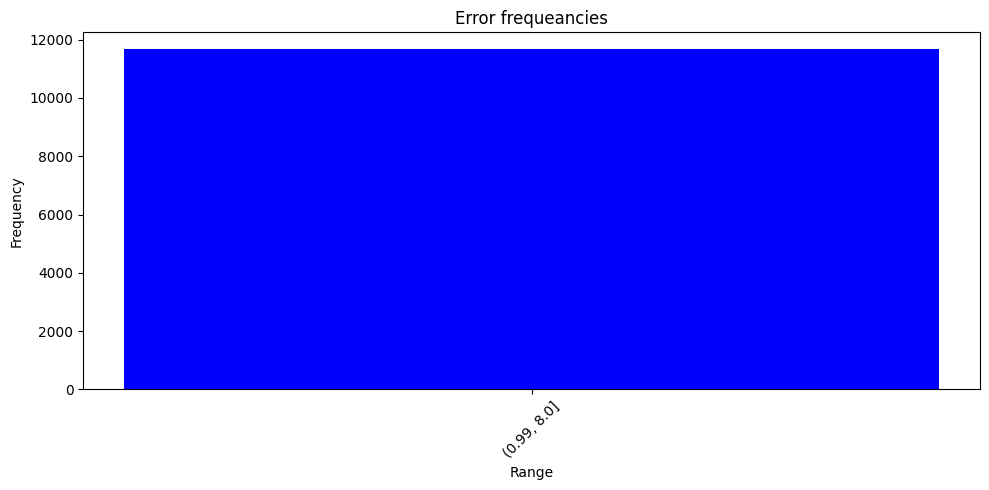

Errors: {'(0.99, 8.0]': 11666}
Error mean: 1.1989542259557688
Error rate: 30.096486249419534 %
Overall mean: 0.3608430937516124


In [32]:
Evaluator.eval_ordinal_classification (result["diff"])

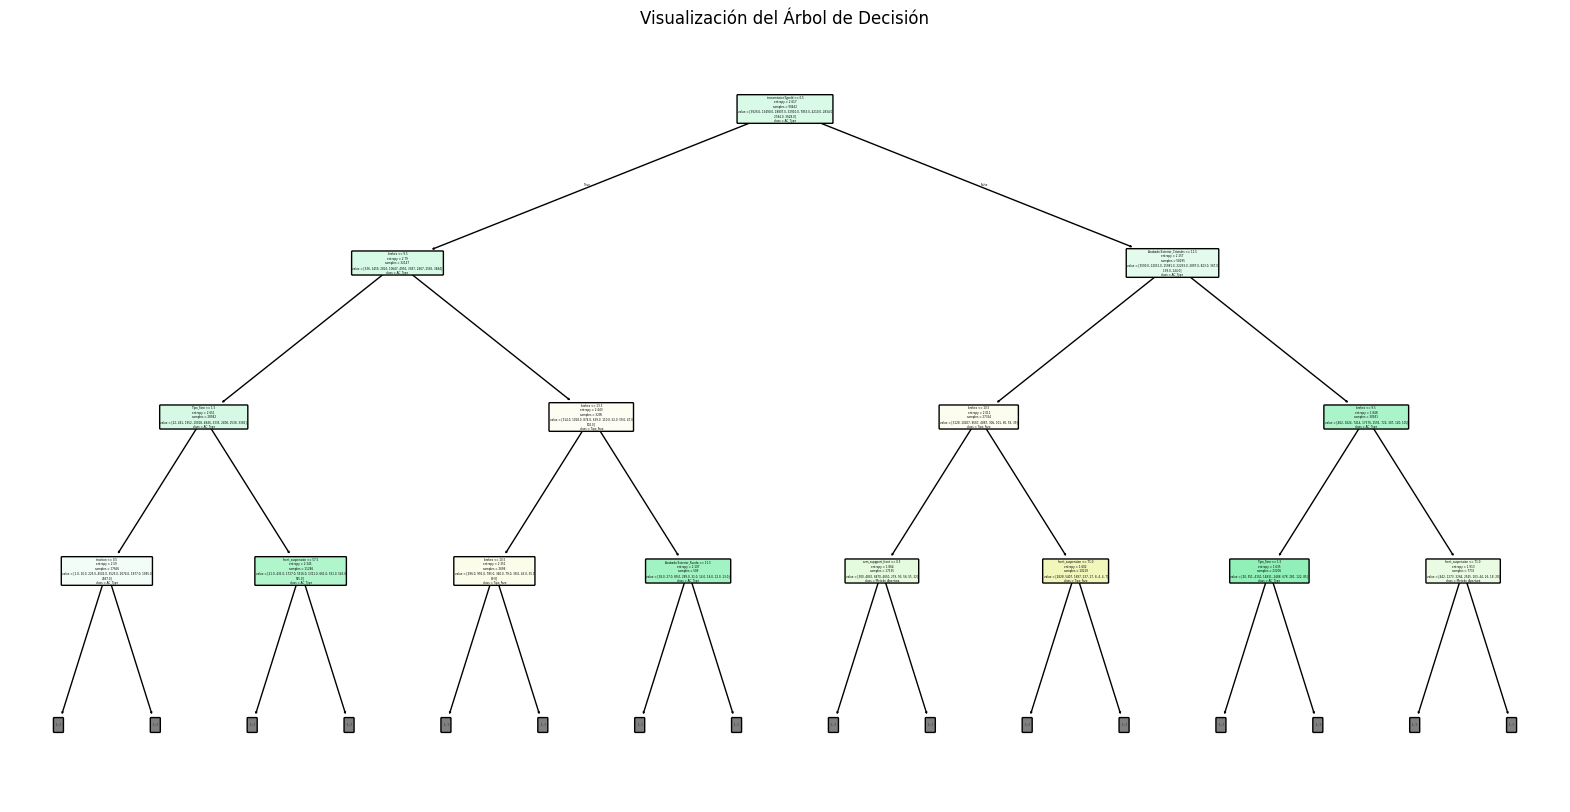

In [33]:
plt.figure(figsize=(20,10))

# Dibujar el árbol de decisión
plot_tree(tree_model, 
          filled=True, 
          rounded=True, 
          class_names=X_train.columns, 
          feature_names=X.columns, 
          max_depth=3)  # Puedes ajustar la profundidad para una mejor visualización o quitar este parámetro para mostrar todo el árbol
plt.title('Visualización del Árbol de Decisión')
plt.show()